# Thematic differences (Slovenia)

DHH23 Parliament group

Author: Pontus H.

In [83]:
# Set the theme here
THEME = 'war_SI'
# Set the output path for the CSV:s and keyword figure
OUTPUT_PATH = '../thematic_differences/'
# Set the output path for the model
MODEL_PATH = '../data/models/'

In [84]:
from cuml.manifold import UMAP
from cuml.cluster.hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer

import pandas as pd

In [85]:
# Optional stopwords
with open('../data/stopwords-si.txt', 'r', encoding='utf-8') as f:
    stopwords = f.read().splitlines()

Set up the BERTopic pipeline

In [86]:
# Parameters
HDBSCAN_MIN_CLUSTER_SIZE = 20
HDBSCAN_MIN_SAMPLES = 1
HDBSCAN_CLUSTER_SELECTION_EPSILON = 0

# Step 1 - Extract embeddings
# embedding_model = SentenceTransformer('all-MiniLM-L6-v2') # English
embedding_model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2') # Other languages

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=10, min_dist=0.0, metric='cosine', random_state=42)

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(
    min_cluster_size=HDBSCAN_MIN_CLUSTER_SIZE,
    min_samples=HDBSCAN_MIN_SAMPLES,
    cluster_selection_epsilon=HDBSCAN_CLUSTER_SELECTION_EPSILON,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True,)

# Step 3 - Cluster reduced embeddings with KMeans
# hdbscan_model = KMeans(n_clusters=100, random_state=42)

# Step 4 - Tokenize topics
# vectorizer_model = CountVectorizer(stop_words="english") # English
vectorizer_model = CountVectorizer(stop_words=stopwords) # Other languages

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# Step 6 - (Optional) Fine-tune topic representations with 
# a `bertopic.representation` model
# representation_model = KeyBERTInspired()
representation_model = MaximalMarginalRelevance(diversity=0.8)

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model, # Step 6 - (Optional) Fine-tune topic representations
  #nr_topics="25",
  calculate_probabilities=True,
  n_gram_range=(1, 3)
)

In [87]:
df = pd.read_csv(f'../data/{THEME}.csv')
df.head()

,ID,Title,Date,Body,Term,Session,Meeting,Sitting,Agenda,Subcorpus,...,Speaker_party,Speaker_party_name,Party_status,Speaker_name,Speaker_gender,Speaker_birth,speech,speech_split,sentiment,speech_length
0,ParlaMint-SI_2017-07-10-SDZ7-Redna-32.u2,Minutes of the National Assembly of the Republ...,2017-07-10,Lower house,7,NaN,32,NaN,NaN,Reference,...,SDS,Slovenska demokratska stranka,Opposition,"Grims, Branko",M,1962,"Spoštovani! Vsekakor predlog, da pod nujno obr...",Ne samo napoved avstrijskega ministra za obra...,-0.165039,2299
1,ParlaMint-SI_2017-07-10-SDZ7-Redna-32.u38,Minutes of the National Assembly of the Republ...,2017-07-10,Lower house,7,NaN,32,NaN,NaN,Reference,...,SDS,Slovenska demokratska stranka,Opposition,"Godec, Jelka",F,1969,"Glede na to, da je predsednik Vlade pravkar de...","Predsednik Vlade, jaz pa vam lahko zdaj zelo ...",-0.625488,2165
2,ParlaMint-SI_2017-07-10-SDZ7-Redna-32.u82,Minutes of the National Assembly of the Republ...,2017-07-10,Lower house,7,NaN,32,NaN,NaN,Reference,...,SDS,Slovenska demokratska stranka,Opposition,"Grims, Branko",M,1962,"Spoštovana gospa ministrica, zgodovina je pač ...",In danes je situacija z vidika migrantske kri...,-0.915039,2175
3,ParlaMint-SI_2017-07-10-SDZ7-Redna-32.u102,Minutes of the National Assembly of the Republ...,2017-07-10,Lower house,7,NaN,32,NaN,NaN,Reference,...,SMC,Stranka modernega centra,Coalition,"Dekleva, Erika",F,1969,"Spoštovana ministrica, lep pozdrav! Moje vpraš...",Na osnovni dogovora o uskladitvi interesov gl...,0.010063,1847
4,ParlaMint-SI_2017-07-10-SDZ7-Redna-32.u106,Minutes of the National Assembly of the Republ...,2017-07-10,Lower house,7,NaN,32,NaN,NaN,Reference,...,SMC,Stranka modernega centra,Coalition,"Dekleva, Erika",F,1969,"Hvala. Ministrica, jaz vas nisem prosila za ce...","Ministrica, jaz vas nisem prosila za celotno ...",-0.790527,1242


In [88]:
df['Speaker_party'].describe()

count     9305
unique      24
top        SDS
freq      2413
Name: Speaker_party, dtype: object

In [89]:
# Reference running time for this cell: 4min 00s
topics, probs = topic_model.fit_transform(df['speech'])


In [90]:
# Reduce outliers
new_topics = topic_model.reduce_outliers(df['speech'], topics, strategy="c-tf-idf", threshold=0.05)

In [91]:
pd.Series(new_topics).value_counts()

2      768
1      409
9      365
5      273
6      266
      ... 
92      25
104     24
105     23
108     22
106     21
Length: 113, dtype: int64

In [92]:
#topic_model.save(f"../data/topic_model_epsilon{HDBSCAN_CLUSTER_SELECTION_EPSILON}_clustersize{HDBSCAN_MIN_CLUSTER_SIZE}.bin")

In [93]:
#topic_model = BERTopic.load("../data/topic_model_epsilon0_clustersize50.bin")

In [94]:
# Number of topics
print(f"Number of topics: {len(pd.Series(new_topics).unique())}")

Number of topics: 113


In [95]:
# The count of speeches per topic. -1 is the noise(outlier) topic
pd.Series(topic_model.hdbscan_model.labels_).value_counts()

-1     4285
 42     161
 85     150
 11     138
 88     138
       ... 
 82      20
 81      20
 27      20
 66      20
 53      20
Length: 113, dtype: int64

In [96]:
topic_model.visualize_topics()

Topics over time

In [97]:
# Reference running time for this cell: 2min 30s
#topics_over_time = topic_model.topics_over_time(df['speech'], df['Date'].to_list(), nr_bins=20)

In [98]:
# Save the topics_over_time dataframe to a feather file
#topics_over_time.to_feather("../data/topics_over_time.feather")

In [99]:
#topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=10)
#topic_model.visualize_topics_over_time(topics_over_time, topics=[0,18])


In [100]:
#topics_over_time[topics_over_time['Topic'] == 0]

In [101]:
topic_word_scores = topic_model.visualize_barchart(width=330, height=330, top_n_topics=10, n_words=10)
# Create the output directory if it does not exist
import os
if not os.path.exists(f"{OUTPUT_PATH}{THEME}"):
    os.makedirs(f"{OUTPUT_PATH}{THEME}")
topic_word_scores.write_image(f"{OUTPUT_PATH}{THEME}/{THEME}_topic_keywords.png")
topic_word_scores

# Word Clouds

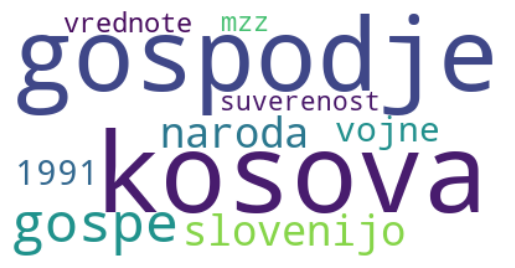

In [102]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=0)

In [103]:
#topic_model.visualize_heatmap(n_clusters=5, top_n_topics=10)

For the top 10 topics, get the percentage of Labour speeches and Conservative speeches. Include the keywords related to the topic.

In [104]:
def get_keywords(topic):
    return [word for word, _ in topic_model.get_topic(topic)]
#get_keywords(0)

In [105]:
speech_topic_party = pd.DataFrame({'topic': new_topics, 'party': df['Speaker_party']})
# Remove the noise topic
speech_topic_party = speech_topic_party[speech_topic_party['topic'] != -1]
# Remove topics > 10
speech_topic_party = speech_topic_party[speech_topic_party['topic'] < 10]
# Drop speeches with no party
speech_topic_party = speech_topic_party.dropna()
# Set the party name to 'OTHER' if the party name does not contain 'SDS' or 'SD'
speech_topic_party.loc[~speech_topic_party['party'].str.contains('SDS|SD'), 'party'] = 'OTHER'
# Set the party name to 'OTHER' if the party name is 'ZLSD'
speech_topic_party.loc[speech_topic_party['party'] == 'ZLSD', 'party'] = 'OTHER'
# Group by party and topic
speech_topic_party = speech_topic_party.groupby(['topic', 'party']).size().reset_index(name='counts')
# Pivot the dataframe
speech_topic_party = speech_topic_party.pivot(index='topic', columns='party', values='counts').fillna(0)
#speech_topic_party.to_csv(f"{OUTPUT_PATH}{THEME}_speeches_topic_party.csv")
speech_topic_party

party,OTHER,SD,SDS
topic,,,
0,159,14,74
1,221,26,162
2,434,100,232
3,162,33,41
4,119,24,54
5,183,33,57
6,190,24,48
7,110,16,31
8,76,16,31


In [106]:
# For each topic, divide the count of speeches by the total count of speeches per party
percentages = speech_topic_party.div(speech_topic_party.sum(axis=0), axis=1)
# Multiply by 100 to get percentages and round to 1 decimal
percentages = (percentages * 100).round(1)
percentages.reset_index()
percentages

party,OTHER,SD,SDS
topic,,,
0,8.7,4.2,8.6
1,12.0,7.8,18.8
2,23.6,29.9,26.9
3,8.8,9.9,4.7
4,6.5,7.2,6.2
5,10.0,9.9,6.6
6,10.3,7.2,5.6
7,6.0,4.8,3.6
8,4.1,4.8,3.6


In [107]:
# Reset the index to get the topic column back and add a new column 'keywords'
percentages = percentages.reset_index()
percentages['keywords'] = percentages['topic'].apply(lambda x: get_keywords(x))
percentages = percentages.set_index('topic')
#percentages.to_csv(f'{OUTPUT_PATH}{THEME}_percentages.csv')
percentages

party,OTHER,SD,SDS,keywords
topic,,,,
0,8.7,4.2,8.6,"[kosova, gospodje, gospe, slovenijo, naroda, v..."
1,12.0,7.8,18.8,"[evropa, val, migrantsko, ograjo, slovenija, m..."
2,23.6,29.9,26.9,"[bom, ministra, zakaj, gospa, vlade, notranje,..."
3,8.8,9.9,4.7,"[policijskih, organiziranosti, nalog, notranje..."
4,6.5,7.2,6.2,"[1942, referenduma, tigr, sodišča, kmetijsko, ..."
5,10.0,9.9,6.6,"[rast, 2003, primanjkljaj, proračunu, bdp, mil..."
6,10.3,7.2,5.6,"[ratifikacijo, unija, eu, zavezništvo, sloveni..."
7,6.0,4.8,3.6,"[orožje, pirotehničnih, direktive, športa, obr..."
8,4.1,4.8,3.6,"[slovenijo, sporazum, evropi, vsi, nova, bodo,..."


In [108]:
# For each topic, divide the count of speeches by the total count of speeches per party
percentages_per_row = speech_topic_party.div(speech_topic_party.sum(axis=1), axis=0)
# Multiply by 100 to get percentages and round to 1 decimal
percentages_per_row = (percentages_per_row * 100).round(1)
#percentages_per_row.to_csv(f'{OUTPUT_PATH}{THEME}_percentages_per_row.csv')
percentages_per_row.reset_index()

party,topic,OTHER,SD,SDS
0,0,64.4,5.7,30.0
1,1,54.0,6.4,39.6
2,2,56.7,13.1,30.3
3,3,68.6,14.0,17.4
4,4,60.4,12.2,27.4
5,5,67.0,12.1,20.9
6,6,72.5,9.2,18.3
7,7,70.1,10.2,19.7
8,8,61.8,13.0,25.2
9,9,49.9,13.4,36.7


Calculate mean sentiment for each topic per party

In [109]:
#sentiment_topic_party = pd.DataFrame({'topic': new_topics, 'party': df['Speaker_party'], 'sentiment': df['sentiment']})
sentiment_topic_party = pd.DataFrame({'topic': new_topics, 'speech_id': df['ID'], 'party': df['Speaker_party'], 'sentiment': df['sentiment'], 'speech_date': df['Date'], 'prob': list(probs), 'speech': df['speech']})
# Remove the noise topic
sentiment_topic_party = sentiment_topic_party[sentiment_topic_party['topic'] != -1]
# Remove topics > 10
sentiment_topic_party = sentiment_topic_party[sentiment_topic_party['topic'] < 10]
# Drop speeches with no party
sentiment_topic_party = sentiment_topic_party.dropna()
# Set the party name to 'OTHER' if the party name does not contain 'SDS' or 'SD'
sentiment_topic_party.loc[~sentiment_topic_party['party'].str.contains('SDS|SD'), 'party'] = 'OTHER'
# Set the party name to 'OTHER' if the party name is 'ZLSD'
sentiment_topic_party.loc[sentiment_topic_party['party'] == 'ZLSD', 'party'] = 'OTHER'
# Create a new dataframe with the relevant speeches and remove
relevant_speeches = sentiment_topic_party.copy()
sentiment_topic_party.drop(columns=['speech', 'speech_date', 'prob'], inplace=True)
# Group by party and topic and take the average sentiment
sentiment_topic_party = sentiment_topic_party.groupby(['topic', 'party']).mean().reset_index()
# speech_topic_party = speech_topic_party.groupby(['topic', 'party']).size().reset_index(name='counts')
# Pivot the dataframe
sentiment_topic_party = sentiment_topic_party.pivot(index='topic', columns='party', values='sentiment').fillna(0).round(2)
#sentiment_topic_party.to_csv(f'{OUTPUT_PATH}{THEME}_sentiment.csv')
sentiment_topic_party

party,OTHER,SD,SDS
topic,,,
0,-0.31,-0.33,-0.36
1,-0.51,-0.37,-0.64
2,-0.64,-0.57,-0.65
3,-0.33,-0.31,-0.33
4,-0.51,-0.45,-0.53
5,-0.33,-0.42,-0.29
6,0.02,0.13,0.03
7,-0.13,0.04,-0.26
8,-0.22,-0.20,-0.53


In [110]:
# Save the topic model
topic_model.save(f"{MODEL_PATH}{THEME}_topic_model.bin")

In [111]:
def get_top_3(topic_id, party_name):
    speeches_for_topic_0_con = relevant_speeches[(relevant_speeches['party'] == party_name) & (relevant_speeches['topic'] == topic_id)]
    speeches_for_topic_0_con['prob'] = speeches_for_topic_0_con['prob'].apply(lambda x: x[topic_id])
    speeches_for_topic_0_con = speeches_for_topic_0_con.sort_values(by='sentiment', ascending=False)
    most_positive = speeches_for_topic_0_con.head(3)
    most_negative = speeches_for_topic_0_con.tail(3)
    return most_positive.append(most_negative).drop_duplicates(subset=['speech_id'])

parties = ['SDS', 'SD', 'OTHER']

max_topic = relevant_speeches['topic'].max()

representative_speeches = get_top_3(0, 'SDS')
for party in parties[1:]:
    representative_speeches = representative_speeches.append(get_top_3(0, party))
for topic_id in range(1,max_topic+1):
    for party in parties:
        representative_speeches = representative_speeches.append(get_top_3(topic_id, party))

# Save the representative speeches to a csv and feather file. Use '"" as the quotechar to avoid issues with the speech text
representative_speeches.to_csv(f'{OUTPUT_PATH}{THEME}/{THEME}_representative_speeches.csv', quotechar='"', index=False)
representative_speeches.reset_index().to_feather(f'{OUTPUT_PATH}{THEME}/{THEME}_representative_speeches.feather')
representative_speeches

,topic,speech_id,party,sentiment,speech_date,prob,speech
915,0,ParlaMint-SI_2021-07-05-SDZ8-Redna-24.u184,SDS,0.663086,2021-07-05,0.193108,"Gospod predsednik, hvala za besedo. Spoštovane..."
4394,0,ParlaMint-SI_2010-03-08-SDZ5-Redna-14.u18,SDS,0.644043,2010-03-08,0.009277,Spoštovani! Vsem zbranim prav lep pozdrav in d...
2063,0,ParlaMint-SI_2013-07-05-SDZ6-Izredna-40.u18,SDS,0.627441,2013-07-05,0.041263,Vsem prav lep pozdrav tudi v imenu Poslanske s...
7292,0,ParlaMint-SI_2018-03-16-SDZ7-Izredna-55.u109,SDS,-1.000000,2018-03-16,0.001979,"Hvala lepa za besedo. Zdaj, tema o prihodnosti..."
4396,0,ParlaMint-SI_2010-03-08-SDZ5-Redna-14.u28,SDS,-1.000000,2010-03-08,0.003880,Ponovno slišimo isto zgodbo. Da v tej skupini ...
...,...,...,...,...,...,...,...
5859,9,ParlaMint-SI_2011-04-12-SDZ5-Izredna-41.u97,OTHER,0.590332,2011-04-12,0.004689,Hvala za besedo gospod predsedujoči. Spoštovan...
7672,9,ParlaMint-SI_2007-02-15-SDZ4-Izredna-26.u8,OTHER,0.560059,2007-02-15,0.007041,Spoštovani! Ta seja Državnega zbora je bila sk...
5016,9,ParlaMint-SI_2014-03-24-SDZ6-Izredna-58.u152,OTHER,-1.000000,2014-03-24,0.010534,Hvala lepa za besedo. Po vsej današnji razprav...
5370,9,ParlaMint-SI_2009-07-16-SDZ5-Izredna-11.u210,OTHER,-1.000000,2009-07-16,0.013941,"No, saj tukaj se ne pojavlja drugo vprašanje k..."


In [112]:
# Create a new dataframe from percentages, percentages_per_row and sentiment_topic_party
concatenated_results = pd.concat([percentages, percentages_per_row, sentiment_topic_party], axis=1)
# Rename the columns to make it easier to understand
concatenated_results.columns = ['pf.OTHER', 'pf.SD', 'pf.SDS', 'keywords', 'tc.OTHER', 'tc.SD', 'tc.SDS', 's.OTHER', 's.SD', 's.SDS']
# Reorder the columns
concatenated_results = concatenated_results[['keywords', 'tc.SDS', 'tc.SD', 'tc.OTHER', 'pf.SDS', 'pf.SD', 'pf.OTHER', 's.SDS', 's.SD', 's.OTHER']]
# Save the results to a csv
concatenated_results.to_csv(f'{OUTPUT_PATH}{THEME}/{THEME}_results.csv')
concatenated_results

,keywords,tc.SDS,tc.SD,tc.OTHER,pf.SDS,pf.SD,pf.OTHER,s.SDS,s.SD,s.OTHER
topic,,,,,,,,,,
0,"[kosova, gospodje, gospe, slovenijo, naroda, v...",30.0,5.7,64.4,8.6,4.2,8.7,-0.36,-0.33,-0.31
1,"[evropa, val, migrantsko, ograjo, slovenija, m...",39.6,6.4,54.0,18.8,7.8,12.0,-0.64,-0.37,-0.51
2,"[bom, ministra, zakaj, gospa, vlade, notranje,...",30.3,13.1,56.7,26.9,29.9,23.6,-0.65,-0.57,-0.64
3,"[policijskih, organiziranosti, nalog, notranje...",17.4,14.0,68.6,4.7,9.9,8.8,-0.33,-0.31,-0.33
4,"[1942, referenduma, tigr, sodišča, kmetijsko, ...",27.4,12.2,60.4,6.2,7.2,6.5,-0.53,-0.45,-0.51
5,"[rast, 2003, primanjkljaj, proračunu, bdp, mil...",20.9,12.1,67.0,6.6,9.9,10.0,-0.29,-0.42,-0.33
6,"[ratifikacijo, unija, eu, zavezništvo, sloveni...",18.3,9.2,72.5,5.6,7.2,10.3,0.03,0.13,0.02
7,"[orožje, pirotehničnih, direktive, športa, obr...",19.7,10.2,70.1,3.6,4.8,6.0,-0.26,0.04,-0.13
8,"[slovenijo, sporazum, evropi, vsi, nova, bodo,...",25.2,13.0,61.8,3.6,4.8,4.1,-0.53,-0.20,-0.22
